In [2]:
pip -q install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip -q install tweet-preprocessor

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip -q install gensim

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install inflect

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import preprocessor as p
import gensim
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import string, unicodedata
import inflect
from nltk import sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jules\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jules\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jules\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
url = "https://raw.githubusercontent.com/julesz12345/Social-Media-Super-Bowl-Analytics/main/gm_tweets.csv"
download = requests.get(url).content
data = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [33]:
def extract_month(data,col):
  data['month'] = [data[col][i].split()[1] for i in range(len(data))]

def extract_frame(data,col):
  data['Tweet'] = [p.clean(data[col][i]) for i in range(len(data))]

def lower(x):
    l = x.lower()
    return l
#Extracting Month
extract_month(data,'created_at')
#Extracting Text from Tweets
extract_frame(data,'Text')
#Lowering the text
data['Tweet'] = data.apply(lambda row : lower(row['Tweet']), axis = 1)
#Removing Punctuation
data['Tweets_Processed'] = data['Tweet'].map(lambda x: re.sub('[-.?!,:;()%\/|""]', '', x))

In [34]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [35]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

## Frequency 

In [36]:
base_data = data[data['Type_of_Tweet'] == 'Tweet'].reset_index(drop = True)
df = base_data.copy()

In [37]:
df.shape

(29648, 23)

In [38]:
def token_(x):
    token = word_tokenize(x)
    return token
df['Tweets_Processed'] = df.apply(lambda row : token_(row['Tweets_Processed']), axis = 1)

In [39]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

In [40]:
df['Tweets_Processed'] = df.apply(lambda row : normalize(row['Tweets_Processed']), axis = 1)

In [41]:
from nltk.probability import FreqDist
fdist = FreqDist()
for i in range(len(df)):
    for word in df['Tweets_Processed'][i]:
        fdist[word]+=1

In [42]:
for i in range(len(df)):
  x = df['Tweets_Processed'][i]
  for j in range(len(x)):
    if x[j] == 'general':
      x[j] = 'generalmotors'
    if x[j] == 'gm':
      x[j] = 'generalmotors'
    if x[j] == 'ev':
      x[j] = 'electric'
    if x[j] == 'evs':
      x[j] = 'electric'
    if x[j] == 'allelectric':
      x[j] = 'electric'

In [43]:
df['Date'] = pd.to_datetime(df['created_at']).apply(lambda x: x.date())
df.reset_index(drop=True, inplace=True)
df['Week_Number'] = [df['Date'][i].isocalendar()[1] for i in range(len(df))]

In [46]:
freq_list

['chevrolet', 'toyota', 'tesla', 'ford', 'generalmotors', 'electric']

In [47]:
freq_list = ['chevrolet' ,'toyota', 'tesla','ford','generalmotors','electric']

In [51]:
for i in range(len(df)):
  x = df['Tweets_Processed'][i]
  for j in range(len(x)):
    if x[j] in freq_list:
      df.loc[i,x[j]] = 1

In [52]:
for i in freq_list:
  df[i] = df[i]*df['Retweet_Count']

In [53]:
df['Competitor'] = df['chevrolet'] + df['toyota'] + df['tesla'] + df['ford']

In [54]:
aggregate_df = df.groupby('Week_Number')[freq_list].sum()

In [55]:
aggregate_df = aggregate_df.loc[aggregate_df.index[aggregate_df.index<30],]

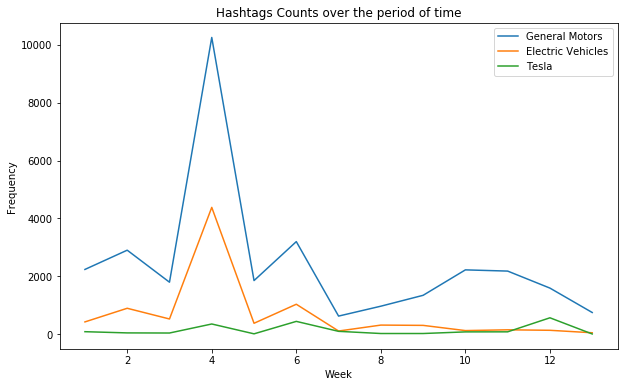

In [56]:
plt.figure(figsize = (10,6))
plt.plot(aggregate_df.index, aggregate_df['generalmotors'],label = 'General Motors')
plt.plot(aggregate_df.index, aggregate_df['electric'],label = 'Electric Vehicles')
plt.plot(aggregate_df.index, aggregate_df['tesla'],label = 'Tesla')
plt.xlabel('Week')
plt.ylabel('Frequency')
plt.title("Hashtags Counts over the period of time")
plt.legend()

# Lift Value

## Pre Event

In [57]:
freq_list = ['generalmotors','electric','tesla','ford','toyota','chevrolet']

In [58]:
df_pre = df[(df['month'] == 'Dec')]
df_pre.reset_index(drop=True, inplace=True)

In [59]:
from nltk.probability import FreqDist
fdist = FreqDist()
for i in range(len(df_pre)):
    for word in df_pre['Tweets_Processed'][i]:
        fdist[word]+=1

freq_l = []
for i in range(len(freq_list)):
    if freq_list[i] in fdist:
        l = freq_list[i], fdist[freq_list[i]]
        freq_l.append(l)
freq_table_pre = pd.DataFrame(freq_l,columns=["Model", "Frequency"])
freq_table_pre.sort_values(by = 'Frequency',ascending = False, inplace = True, ignore_index=True)

freq_table_pre

,Model,Frequency
0,generalmotors,4160
1,electric,324
2,ford,224
3,tesla,127
4,chevrolet,60
5,toyota,50


In [60]:
cooccur_mat_pre = pd.DataFrame(np.zeros((len(freq_list),len(freq_list))), columns=freq_list, index=freq_list)

for rows in range(len(df_pre)):
    for i in range(len(freq_list)):
        if freq_list[i] in df_pre['Tweets_Processed'][rows]:
            for j in range(i+1,len(freq_list)):
                if freq_list[j] in df_pre['Tweets_Processed'][rows]:
                    cooccur_mat_pre[freq_list[i]][freq_list[j]] = cooccur_mat_pre[freq_list[i]][freq_list[j]] + 1
                    cooccur_mat_pre[freq_list[j]][freq_list[i]] = cooccur_mat_pre[freq_list[i]][freq_list[j]]

In [61]:
lift_pre =  pd.DataFrame(np.zeros((len(freq_list),len(freq_list))), columns=freq_list, index=freq_list)

total = len(df_pre)
for i in range(len(cooccur_mat_pre)):
    for j in range(len(cooccur_mat_pre)):
        lift_pre[freq_list[i]][freq_list[j]] = total*(cooccur_mat_pre[freq_list[i]][freq_list[j]]/
                                                    (freq_table_pre.iloc[i,1]*freq_table_pre.iloc[j,1]))
        
lift_pre

,generalmotors,electric,tesla,ford,toyota,chevrolet
generalmotors,0.000000,0.542512,0.317619,1.397229,0.655665,0.753317
electric,0.542512,0.000000,0.767637,1.100078,0.716461,0.859753
tesla,0.317619,0.767637,0.000000,3.916760,4.145238,0.000000
ford,1.397229,1.100078,3.916760,0.000000,8.225197,3.290079
toyota,0.655665,0.716461,4.145238,8.225197,0.000000,0.000000
chevrolet,0.753317,0.859753,0.000000,3.290079,0.000000,0.000000


## Post Event

In [62]:
df_post = df[(df['month'] == 'Feb') | (df['month'] == 'Mar') | (df['month'] == 'Apr')|(df['month'] == 'Jan')]
df_post.reset_index(drop=True, inplace=True)

In [63]:
from nltk.probability import FreqDist
fdist = FreqDist()
for i in range(len(df_post)):
    for word in df_post['Tweets_Processed'][i]:
        fdist[word]+=1

freq_l = []
for i in range(len(freq_list)):
    if freq_list[i] in fdist:
        l = freq_list[i], fdist[freq_list[i]]
        freq_l.append(l)
freq_table_post = pd.DataFrame(freq_l,columns=["Model", "Frequency"])
freq_table_post.sort_values(by = 'Frequency',ascending = False, inplace = True, ignore_index=True)

freq_table_post

,Model,Frequency
0,generalmotors,27754
1,electric,6255
2,tesla,1064
3,ford,858
4,toyota,303
5,chevrolet,256


In [64]:
cooccur_mat_post = pd.DataFrame(np.zeros((len(freq_list),len(freq_list))), columns=freq_list, index=freq_list)

for rows in range(len(df_post)):
    for i in range(len(freq_list)):
        if freq_list[i] in df_post['Tweets_Processed'][rows]:
            for j in range(i+1,len(freq_list)):
                if freq_list[j] in df_post['Tweets_Processed'][rows]:
                    cooccur_mat_post[freq_list[i]][freq_list[j]] = cooccur_mat_post[freq_list[i]][freq_list[j]] + 1
                    cooccur_mat_post[freq_list[j]][freq_list[i]] = cooccur_mat_post[freq_list[i]][freq_list[j]]

In [65]:
lift_post =  pd.DataFrame(np.zeros((len(freq_list),len(freq_list))), columns=freq_list, index=freq_list)

total = len(df_post)
for i in range(len(cooccur_mat_post)):
    for j in range(len(cooccur_mat_post)):
        lift_post[freq_list[i]][freq_list[j]] = total*(cooccur_mat_post[freq_list[i]][freq_list[j]]/
                                                    (freq_table_post.iloc[i,1]*freq_table_post.iloc[j,1]))
        
lift_post

,generalmotors,electric,tesla,ford,toyota,chevrolet
generalmotors,0.000000,0.716093,0.794809,0.835099,0.886776,0.707087
electric,0.716093,0.000000,1.541184,0.628945,0.455598,0.784353
tesla,0.794809,1.541184,0.000000,3.468117,3.571131,0.288189
ford,0.835099,0.628945,3.468117,0.000000,10.165501,0.833889
toyota,0.886776,0.455598,3.571131,10.165501,0.000000,0.674660
chevrolet,0.707087,0.784353,0.288189,0.833889,0.674660,0.000000


In [66]:
lift_pre

,generalmotors,electric,tesla,ford,toyota,chevrolet
generalmotors,0.000000,0.542512,0.317619,1.397229,0.655665,0.753317
electric,0.542512,0.000000,0.767637,1.100078,0.716461,0.859753
tesla,0.317619,0.767637,0.000000,3.916760,4.145238,0.000000
ford,1.397229,1.100078,3.916760,0.000000,8.225197,3.290079
toyota,0.655665,0.716461,4.145238,8.225197,0.000000,0.000000
chevrolet,0.753317,0.859753,0.000000,3.290079,0.000000,0.000000


# Hashtags

In [67]:
base_data['Retweet_Count']= base_data['Retweet_Count'] +1

In [69]:
#Unique Hash Tags
hash = []
for i in range(len(base_data['Text'])):
  x = base_data['Text'][i].split()
  for j in range(len(x)):
    if x[j][0] =='#':
      hash.append(x[j])
hash = pd.DataFrame(hash, columns= ['Hash'])['Hash'].value_counts()[0:100].index.to_list()
for i in range(len(base_data['Text'])):
  x = base_data['Text'][i].split()
  for j in range(len(x)):
    if x[j] in hash:
      base_data.loc[i,x[j]] = 1

In [70]:
for i in hash:
  base_data[i] = base_data[i]*base_data['Retweet_Count']

In [71]:
base_data['#GeneralMotors'] = base_data['#GeneralMotors'] +base_data['#GM'] +base_data['#generalmotors']  +base_data['#gm'] +base_data['#General'] 
base_data['#ElectricVehicles'] = base_data['#ElectricVehicles'] +base_data['#EV']+base_data['#EVs'] +base_data['#electricvehicles']+base_data['#ev']+base_data['#ElectricVehicle']+base_data['#electric']+base_data['#electriccars']+base_data['#electricvehicle']
base_data['#Chevrolet'] = base_data['#Chevrolet'] +base_data['#chevrolet']
delete = ['#GeneralMotors','#ElectricVehicles' ,'#Tesla', '#SuperBowl', '#Chevrolet', '#Ford', '#Volkswagen']
drop = [x for x in hash if x not in delete]
base_data.drop(drop, axis =1 , inplace=True)


In [72]:
base_data['Date'] = pd.to_datetime(base_data['created_at']).apply(lambda x: x.date())
base_data.reset_index(drop=True, inplace=True)
base_data['Week_Number'] = [base_data['Date'][i].isocalendar()[1] for i in range(len(base_data))]

In [73]:
base_data = base_data[base_data['Week_Number']<15]
aggregate_hash = base_data.groupby('Week_Number')[['#GeneralMotors', '#ElectricVehicles', '#Tesla', '#SuperBowl',
       '#Chevrolet', '#Ford', '#Volkswagen']].sum()

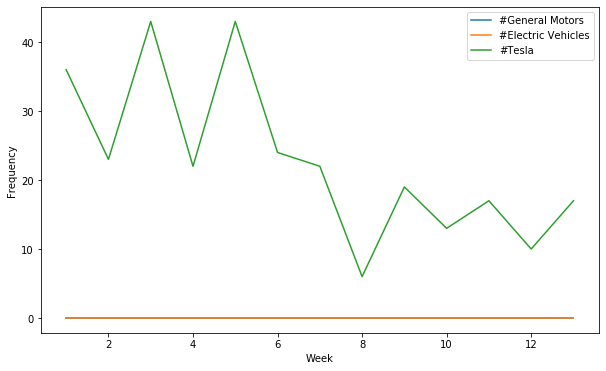

In [74]:
plt.figure(figsize = (10,6))
plt.plot(aggregate_hash.index, aggregate_hash['#GeneralMotors'],label = '#General Motors')
plt.plot(aggregate_hash.index, aggregate_hash['#ElectricVehicles'],label = '#Electric Vehicles')
plt.plot(aggregate_hash.index, aggregate_hash['#Tesla'],label = '#Tesla')
plt.xlabel('Week')
plt.ylabel('Frequency')
plt.legend()

# Sentiment Analysis

In [75]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jules\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [76]:
analyser = SentimentIntensityAnalyzer()

In [77]:
i=0

compval1 = [ ]

while (i<len(base_data)):

    k = analyser.polarity_scores(base_data.iloc[i]['Tweets_Processed'])
    compval1.append(k['compound'])
    
    i = i+1

compval1 = np.array(compval1)

len(compval1)

25962

In [78]:
base_data['VADER score'] = compval1

C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import os
import random

from wordcloud import WordCloud, STOPWORDS

In [80]:
i = 0

predicted_value = [ ]

while(i<len(base_data)):
    if ((base_data.iloc[i]['VADER score'] >= 0.50)):
        predicted_value.append('positive')
        i = i+1
    elif ((base_data.iloc[i]['VADER score'] < 0.5) & (base_data.iloc[i]['VADER score'] > -0.5)):
        predicted_value.append('neutral')
        i = i+1
    elif ((base_data.iloc[i]['VADER score'] <= -0.5)):
        predicted_value.append('negative')
        i = i+1
base_data['predicted sentiment'] = predicted_value

C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [81]:
base_data['predicted sentiment'] = base_data['predicted sentiment'].astype(str)

C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
df = base_data[base_data['predicted sentiment']=='negative']
stopwords = set(STOPWORDS)
stopwords.add("general")
stopwords.add("motor")
stopwords.add("motors")

words = ' '.join(df['Tweets_Processed'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])

wordcloud_negative = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500).generate(cleaned_word)

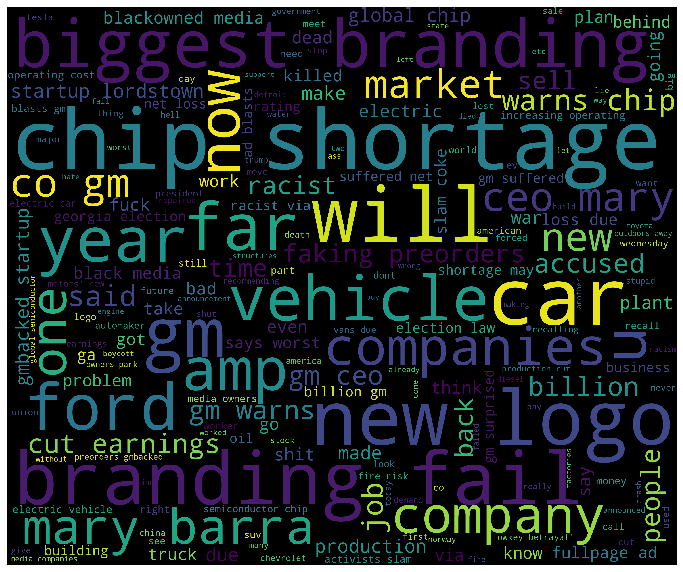

In [83]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.show()

In [84]:
df = base_data[base_data['predicted sentiment']=='positive']
stopwords = set(STOPWORDS)
stopwords.add("general")
stopwords.add("motor")
stopwords.add("super")
stopwords.add("bowl")
stopwords.add("motors")

words = ' '.join(df['Tweets_Processed'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])

wordcloud_negative = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500).generate(cleaned_word)

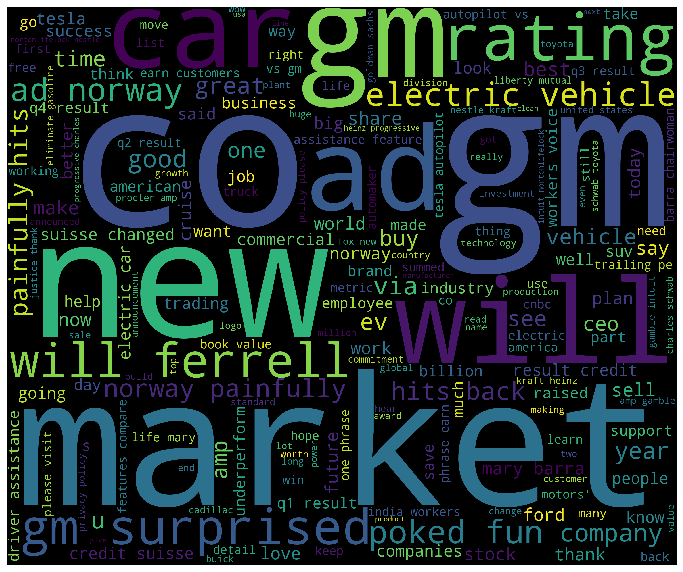

In [85]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.show()

In [86]:
base_data.head()

,Tweet_ID,User_Name,Mentioned_User_Name,Author_Of_Original_Tweet,created_at,Location,Followers_Count,Following_Count,Listed_Count,Reply_Count,...,#ElectricVehicles,#Chevrolet,#Tesla,#Ford,#Volkswagen,#SuperBowl,Date,Week_Number,VADER score,predicted sentiment
0,1.378750e+18,bizwomen,['bizwomen'],NaN,Sun Apr 04 17:00:15 +0000 2021,NaN,7698,2500,244,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-04,13,-0.3182,neutral
1,1.378750e+18,JasonAckery3rd,"['BikingMommy', 'heatherwetzler', 'Jeffdc5', '...",NaN,Sun Apr 04 16:55:32 +0000 2021,NaN,64,357,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-04,13,0.2960,neutral
2,1.378750e+18,_Grand_Wazoo_,['thehill'],NaN,Sun Apr 04 16:43:34 +0000 2021,"Arlington, Texas",498,1505,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-04,13,-0.8316,negative
3,1.378750e+18,paypolitan,"['CryptoPawn88', 'CryptoSays', 'PolkaVentures']",NaN,Sun Apr 04 16:42:38 +0000 2021,NaN,3544,2,22,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-04,13,0.6249,positive
4,1.378750e+18,netbacker,['netbacker'],NaN,Sun Apr 04 16:39:04 +0000 2021,"Santa Clara, CA",4303,4890,300,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-04,13,0.0000,neutral


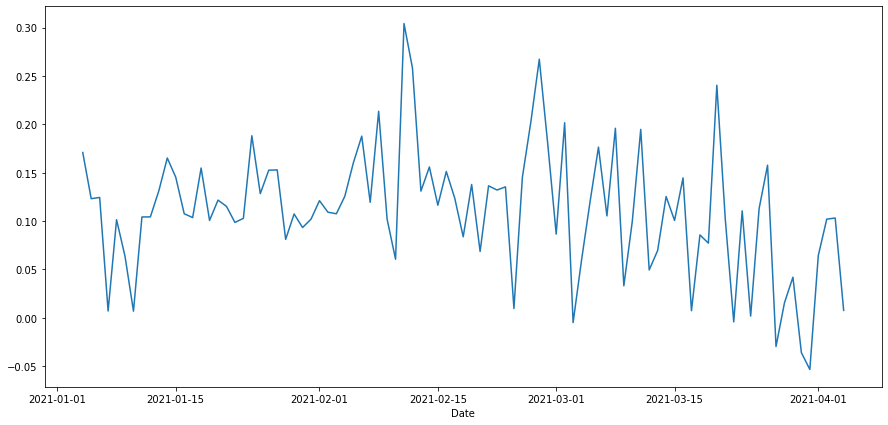

In [87]:
fig, ax = plt.subplots(figsize=(15,7))
base_data.groupby("Date").mean()['VADER score'].plot(ax=ax)

plt.show()

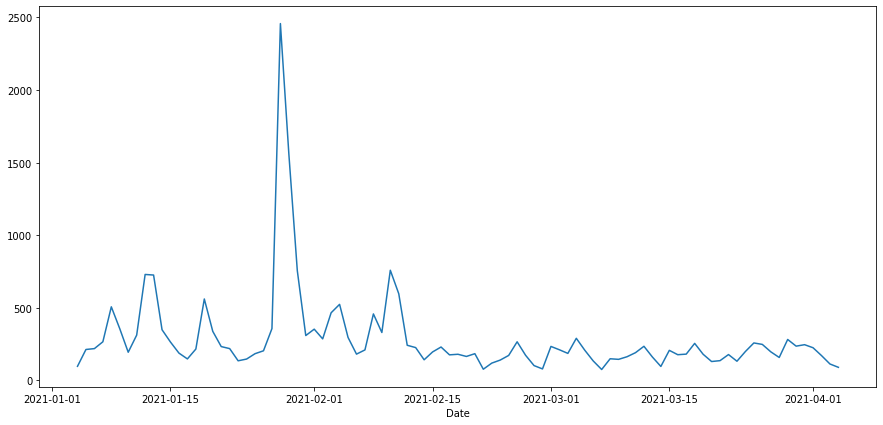

In [88]:
fig, ax = plt.subplots(figsize=(15,7))
base_data.groupby("Date").count()['VADER score'].plot(ax=ax)

plt.show()

In [89]:
base_data.groupby('Week_Number').mean()['VADER score']

Week_Number
1     0.079442
2     0.123456
3     0.119445
4     0.099097
5     0.127880
6     0.171747
7     0.116064
8     0.143987
9     0.101306
10    0.107211
11    0.101476
12    0.057668
13    0.025162
Name: VADER score, dtype: float64

# Google Trends

In [90]:
pip install pytrends

Note: you may need to restart the kernel to use updated packages.


In [91]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

In [92]:
import time
from functools import reduce
import pandas as pd
import plotly.express as px

## General Motors - Last 6 months

In [93]:
q = pytrends.suggestions("general motors")
q

[{'mid': '/m/035nm',
  'title': 'General Motors',
  'type': 'Vehicle manufacturer'},
 {'mid': '/m/0195rf', 'title': 'Vauxhall Motors', 'type': 'Car manufacturer'},
 {'mid': '/g/11bw46ft1f', 'title': 'General Motors', 'type': 'Topic'},
 {'mid': '/m/0j72pxm', 'title': 'GMC', 'type': 'Automobile make'},
 {'mid': '/m/01wxjd', 'title': 'GMC', 'type': 'Automobile manufacturer'}]

### Worldwide Results

In [94]:
kw_list = ["/m/035nm"]
pytrends.build_payload(kw_list, timeframe='2020-07-01 2021-04-04', geo='', gprop='')

In [95]:
data=pytrends.interest_over_time()
time.sleep(60)

data_topics = pytrends.related_topics()
data_topics_rising = data_topics['/m/035nm']['rising']
data_topics_top = data_topics['/m/035nm']['top']

data_location = pytrends.interest_by_region(resolution='COUNTRY', inc_low_vol=True, inc_geo_code=False)

data_queries = pytrends.related_queries()
data_queries_top = data_topics['/m/035nm']['top']
data_queries_rising = data_topics['/m/035nm']['rising']

In [96]:
pytrends.build_payload(kw_list, timeframe='2020-07-01 2021-04-04', geo='', gprop='news')
time.sleep(60)
data_news = pytrends.interest_over_time()

pytrends.build_payload(kw_list, timeframe='2020-07-01 2021-04-04', geo='', gprop='images')
time.sleep(60)
data_images = pytrends.interest_over_time()

pytrends.build_payload(kw_list, timeframe='2020-07-01 2021-04-04', geo='', gprop='youtube')
time.sleep(60)
data_youtube = pytrends.interest_over_time()

In [97]:
data.rename(columns={'/m/035nm':'General Motors Web Search'},inplace=True)
data_news.rename(columns={'/m/035nm':'General Motors News'},inplace=True)
data_images.rename(columns={'/m/035nm':'General Motors Images'},inplace=True)
data_youtube.rename(columns={'/m/035nm':'General Motors Youtube'},inplace=True)
dfs = [data, data_news, data_images, data_youtube]
data_merge = reduce(lambda left,right: pd.merge(left,right,on='date'), dfs)
data_merge.drop(columns=['isPartial_x','isPartial_y'],axis=1,inplace=True)
data_merge.reset_index(inplace=True)

In [98]:
data_merge = data_merge[data_merge['date']>'2020-11-01']

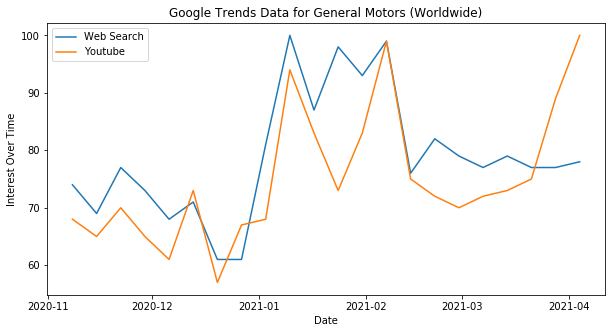

In [99]:
plt.figure(figsize=(10,5))
plt.plot(data_merge['date'], data_merge['General Motors Web Search'],label='Web Search')
plt.plot(data_merge['date'], data_merge['General Motors Youtube'],label='Youtube')
plt.xlabel("Date")
plt.ylabel("Interest Over Time")
plt.legend(loc='best')
plt.title("Google Trends Data for General Motors (Worldwide)")
plt.show()

### US Results

In [100]:
pytrends.build_payload(kw_list, timeframe='2020-07-01 2021-04-04', geo='US', gprop='')
time.sleep(60)
data_US = pytrends.interest_over_time()

In [101]:
data_US=pytrends.interest_over_time()
time.sleep(60)

data_US_topics = pytrends.related_topics()
data_US_topics_rising = data_US_topics['/m/035nm']['rising']
data_US_topics_top = data_US_topics['/m/035nm']['top']

data_US_location = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=False)

data_US_queries = pytrends.related_queries()
data_US_queries_top = data_US_queries['/m/035nm']['top']
data_US_queries_rising = data_US_queries['/m/035nm']['rising']

In [102]:
pytrends.build_payload(kw_list, timeframe='2020-07-01 2021-04-04', geo='', gprop='news')
time.sleep(60)
data_US_news = pytrends.interest_over_time()

pytrends.build_payload(kw_list, timeframe='2020-07-01 2021-04-04', geo='', gprop='images')
time.sleep(60)
data_US_images = pytrends.interest_over_time()

pytrends.build_payload(kw_list, timeframe='2020-07-01 2021-04-04', geo='', gprop='youtube')
time.sleep(60)
data_US_youtube = pytrends.interest_over_time()

In [103]:
data_US.rename(columns={'/m/035nm':'General Motors Web Search'},inplace=True)
data_US_news.rename(columns={'/m/035nm':'General Motors News'},inplace=True)
data_US_images.rename(columns={'/m/035nm':'General Motors Images'},inplace=True)
data_US_youtube.rename(columns={'/m/035nm':'General Motors Youtube'},inplace=True)
dfs = [data_US, data_US_news, data_US_images, data_US_youtube]
data_US_merge = reduce(lambda left,right: pd.merge(left,right,on='date'), dfs)
data_US_merge.reset_index(inplace=True)

In [104]:
data_US_merge = data_US_merge[data_US_merge['date']>'2020-11-01']

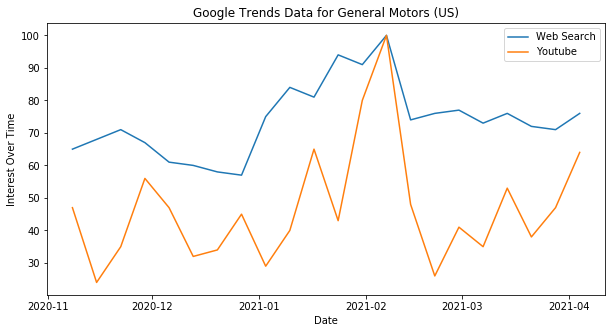

In [105]:
plt.figure(figsize=(10,5))
plt.plot(data_US_merge['date'], data_US_merge['General Motors Web Search'],label='Web Search')
plt.plot(data_US_merge['date'], data_US_merge['General Motors Youtube'],label='Youtube')
plt.xlabel("Date")
plt.ylabel("Interest Over Time")
plt.legend(loc='best')
plt.title("Google Trends Data for General Motors (US)")
plt.show()

In [106]:
data_US_location.nlargest(10,'/m/035nm')

,/m/035nm
geoName,
Michigan,100
North Dakota,45
Indiana,40
Missouri,36
Wisconsin,35
Wyoming,35
Iowa,34
Ohio,34
Nebraska,33


In [107]:
data_US_topics_top[['topic_title','value']]

,topic_title,value
0,Stock,100
1,NYSE:GM,74
2,Chevrolet,42
3,Chevrolet,42
4,General Motors,35
5,GMC,32
6,GMC,32
7,Engine,26
8,Ford,25
9,Share price,25
